In [1]:
import tensorflow as tf
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import random 
from keras.datasets import mnist
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Activation 
from keras import backend as k 


In [12]:
num_classes= 10 
def euclid_dist(vects):
    x, y = vects
    sum_square = k.sum(k.square(x-y), axis=1, keepdims=True)
    return k.sqrt(k.maximum(sum_square, k.epsilon()))

def eucl_dist_output(shapes):
    shape1, shape2 = shapes
    return(shape1[0], 1)

In [2]:
#contrastive loss =  y * D2 + (1-y) * max(margin - D, 0)2
def contrastrive_loss(y_true, y_pred):
    y_true = tf.dtypes.cast(y_true, tf.float64)
    y_pred = tf.dtypes.cast(y_pred, tf.float64)
    margin = 1
    sqaure_pred = k.square(y_pred)
    margin_square = k.square(k.maximum(margin - y_pred, 0))
    return k.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)

In [3]:
def create_pairs(x, digit_indices):
    pairs = []
    labels = []

    n =  min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i+1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)
  

In [4]:
def base_net(input_shape):
    input = Input(shape = input_shape)
    x = Conv2D(4, (5,5), activation = 'tanh')(input)
    x = AveragePooling2D(pool_size=(2,2))(x)
    x = Conv2D(16, (5,5), activation = 'tanh')(x)
    x = AveragePooling2D(pool_size=(2,2))(x)
    x = Flatten()(x)
    x = Dense(10, activation = 'tanh')(x)
    model = Model(input, x)
    model.summary()
    return model

In [5]:
def compute_accuracy(y_true, y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

def accuracy(y_true, y_pred):
    return k.mean(k.equal(y_true, k.cast(y_pred < 0.5, y_true.dtype)))

In [6]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [7]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
input_shape = (1, 28, 28)
print(X_train.shape)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
Y_train = Y_train.astype('float32')
Y_test = Y_test.astype('float32')
X_train /= 255
X_test /= 255

(60000, 28, 28, 1)


In [8]:
input_shape = X_train.shape[1:]

In [9]:
print(input_shape)

(28, 28, 1)


In [13]:
digit_indices = [np.where(Y_train == i )[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(X_train, digit_indices)

In [14]:
digit_indices = [np.where(Y_test == i )[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(X_test, digit_indices)

In [15]:
base_network = base_net(input_shape)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 4)         104       
_________________________________________________________________
average_pooling2d_2 (Average (None, 12, 12, 4)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 16)          1616      
_________________________________________________________________
average_pooling2d_3 (Average (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570

In [16]:
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
processed_a = base_network(input_a)
processed_b = base_network(input_b)
distance = Lambda(euclid_dist, output_shape =eucl_dist_output)([processed_a, processed_b])
model =  Model([input_a, input_b], distance)

In [17]:
model.compile(loss= contrastrive_loss, optimizer='adam', metrics = [accuracy])
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y, batch_size=128, epochs=20, validation_data=([te_pairs[:,0], te_pairs[:, 1]], te_y))

Epoch 1/20
847/847 [==============================] - 60s 65ms/step - loss: 0.1170 - accuracy: 0.8637 - val_loss: 0.0800 - val_accuracy: 0.9257
Epoch 2/20
847/847 [==============================] - 56s 66ms/step - loss: 0.0755 - accuracy: 0.9331 - val_loss: 0.0611 - val_accuracy: 0.9504
Epoch 3/20
847/847 [==============================] - 55s 65ms/step - loss: 0.0620 - accuracy: 0.9504 - val_loss: 0.0527 - val_accuracy: 0.9602
Epoch 4/20
847/847 [==============================] - 62s 73ms/step - loss: 0.0553 - accuracy: 0.9580 - val_loss: 0.0507 - val_accuracy: 0.9632
Epoch 5/20
847/847 [==============================] - 65s 77ms/step - loss: 0.0511 - accuracy: 0.9626 - val_loss: 0.0459 - val_accuracy: 0.9666
Epoch 6/20
847/847 [==============================] - 59s 70ms/step - loss: 0.0481 - accuracy: 0.9658 - val_loss: 0.0440 - val_accuracy: 0.9677
Epoch 7/20
847/847 [==============================] - 62s 73ms/step - loss: 0.0460 - accuracy: 0.9683 - val_loss: 0.0426 - val_accuracy:

In [18]:
y_pred = model.predict([tr_pairs[:,0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:,0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)
print("Accuracy on training Dataset", (100 * tr_acc))
print("Accuracy on testing Dataset", (100 * te_acc))

Accuracy on training Dataset 97.86623616236162
Accuracy on testing Dataset 97.67676767676767


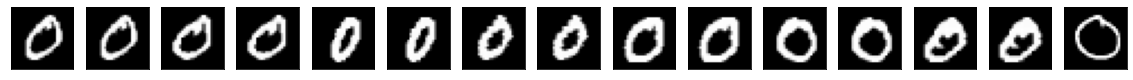

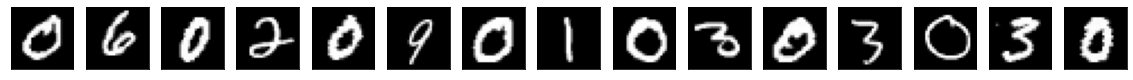

[0.08425854]
similar
[1.0874494]
Disimilar
[0.06685951]
similar
[1.2177998]
Disimilar
[0.12766184]
similar
[1.3127824]
Disimilar
[0.2287441]
similar
[1.0556026]
Disimilar
[0.20183459]
similar
[1.1794101]
Disimilar
[0.09139365]
similar
[1.4104253]
Disimilar
[0.18450776]
similar
[1.3353558]
Disimilar
[0.09869737]
similar


In [19]:
import matplotlib.pyplot as plt 
from PIL import Image 
num_of_item = 15
im = tf.keras.preprocessing.image.array_to_img(tr_pairs[1, 0], data_format = None, scale=True, dtype=None)
plt.figure(figsize=(20, 10))
for item in range(num_of_item):
    display = plt.subplot(1, num_of_item, item+1)
    im = tf.keras.preprocessing.image.array_to_img(tr_pairs[item, 0], data_format = None, scale=True, dtype=None)
    plt.imshow(im, cmap='gray')
    display.get_xaxis().set_visible(False)
    display.get_yaxis().set_visible(False)
plt.show()
plt.figure(figsize=(20, 10))
for item in range(num_of_item):
    display = plt.subplot(1, num_of_item, item+1)
    im = tf.keras.preprocessing.image.array_to_img(tr_pairs[item, 1], data_format = None, scale=True, dtype=None)
    plt.imshow(im, cmap='gray')
    display.get_xaxis().set_visible(False)
    display.get_yaxis().set_visible(False)
plt.show()
for i in range(num_of_item):
    print(y_pred[i])
    print( 'similar' if np.round(y_pred[i]) == 0 else 'Disimilar')